In [1]:
# Initial imports
import time
start = time.time()

import os
import sys
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle


end = time.time()
print(f'Imports took {end-start} seconds')


Imports took 2.9695472717285156 seconds


In [2]:
major_files_path = 'Audio_Files/Major/'
minor_files_path = 'Audio_files/Minor/'
major_sample_1 = 'Major_0.wav'

IPython.display.Audio(f'{major_files_path}{major_sample_1}', rate=44100)

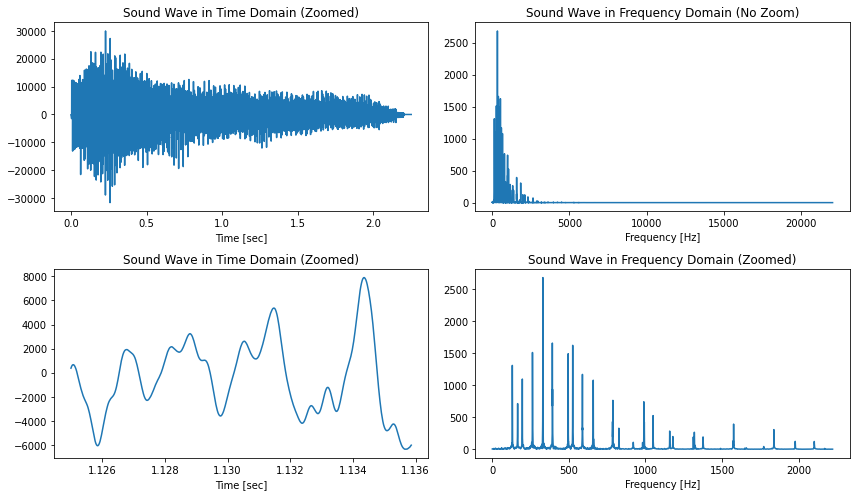

In [3]:
# Code referenced from another notebook by Ahmet Celik
fs, signal = wavfile.read(f'{major_files_path}{major_sample_1}') # get a frequency sample and signal from a wavfile
N = len(signal)
time = np.linspace(0., N/fs, N)

# Fourier Transform
y_freq = fftfreq(N, 1/fs)[:N//2] # array for frequency stamps
signal_f = fft(signal) # Signal in frequency domain
signal_f_onesided = 2.0/N * np.abs(signal_f[0:N//2]) # postive terms

# Plotting signal in time and frequency domains
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes[0,0].plot(time, signal)
axes[0,0].set_title("Sound Wave in Time Domain (Zoomed)")
axes[0,0].set(xlabel="Time [sec]")
axes[0,1].plot(y_freq, signal_f_onesided)
axes[0,1].set_title("Sound Wave in Frequency Domain (No Zoom)")
axes[0,1].set(xlabel="Frequency [Hz]")

axes[1,0].plot(time[(N//2):(N//2+480)], signal[(N//2):(N//2+480)])
axes[1,0].set_title("Sound Wave in Time Domain (Zoomed)")
axes[1,0].set(xlabel="Time [sec]")
axes[1,1].plot(y_freq[:5000], signal_f_onesided[:5000])
axes[1,1].set_title("Sound Wave in Frequency Domain (Zoomed)")
axes[1,1].set(xlabel="Frequency [Hz]")
fig.tight_layout()
plt.show()

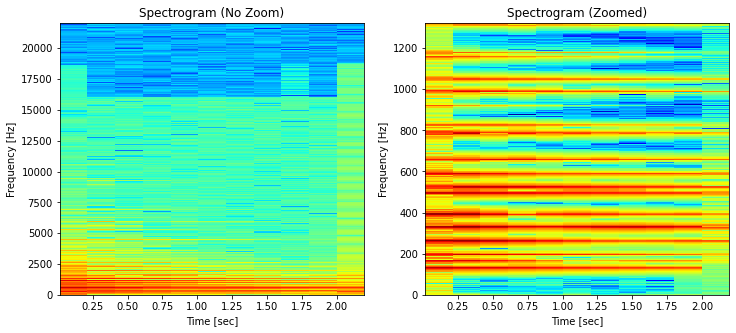

In [4]:
# applying spectrogram
f, t, Sxx = spectrogram(signal, fs, nperseg=10000, nfft=50000)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].pcolormesh(t, f, np.log(Sxx), cmap='jet', shading='auto')
axes[0].set_title('Spectrogram (No Zoom)')
axes[0].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
axes[1].pcolormesh(t, f[:1500], np.log(Sxx)[:1500,:], cmap='jet', shading='auto')
axes[1].set_title('Spectrogram (Zoomed)')
axes[1].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
plt.show()

Harmonics: [ 131.  165.  196.  262.  330.  392.  496.  525.  588.  659.  787.  826.
  989. 1050. 1158. 1179. 1312. 1319. 1376. 1576. 1838.]


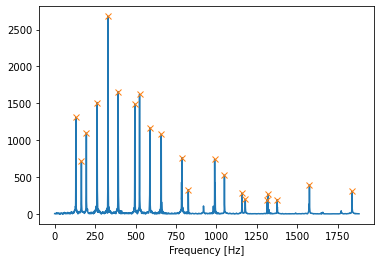

In [5]:
# h: height treshold. Defined as 5% of the max value
h = signal_f_onesided.max()*.05
peaks, _ = find_peaks(signal_f_onesided, distance=10, height=h)

freq_50_index = np.abs(y_freq - 50).argmin() # finding index for 50 Hz
peaks = peaks[peaks > freq_50_index] # filtering peaks less than 50 Hz
harmonics = y_freq[peaks]
print(f'Harmonics: {np.round(harmonics)}')

# Plot
i = peaks.max() + 100
plt.plot(y_freq[:i], signal_f_onesided[:i])
plt.plot(y_freq[peaks], signal_f_onesided[peaks], 'x')
plt.xlabel('Frequency [Hz]')
plt.show()

In [10]:
# Method to read sound file, apply Fourier Transformation, find and return peak frequencies
# Input: 
# --- path = path of sound file
# --- print_peaks = true to plot peaks
# Output: Frequency peaks

def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    N = len(X)
    X_F = fft(X)
    X_F_onesided = 2.0/N * np.abs(X_F[0:N//2])
    freqs = fftfreq(N, 1/fs)[:N//2]
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    h = X_F_onesided.max()*.05
    peaks, _ = find_peaks(X_F_onesided, distance=10, height=h)
    peaks = peaks[peaks > freq_50_index]
    harmonics = np.round(freqs[peaks], 2)
    if print_peaks:
        i = peaks.max() + 100
        plt.plot(freqs[:i], X_F_onesided[:i])
        plt.plot(freqs[peaks], X_F_onesided[peaks], 'x')
        plt.xlabel('Frequency [Hz]')
        plt.show()
    return harmonics

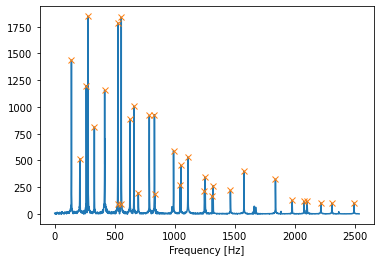

Harmonics: [ 139.  209.  262.  278.  330.  415.  525.  530.  550.  554.  626.  659.
  696.  787.  830.  834.  989. 1043. 1050. 1109. 1247. 1253. 1313. 1319.
 1463. 1575. 1838. 1978. 2077. 2102. 2217. 2309. 2493.]


In [12]:
# Another example to check if method is working correctly
minor_sample_1 = 'Minor_10.wav'
harmonics_2 = find_harmonics(f'{minor_files_path}{minor_sample_1}', print_peaks=True)
print(f'Harmonics: {np.round(harmonics_2)}')

***Importing Dataset***

In [13]:
path = 'AudioFiles/'
data = []
max_harm_length = 0 # keep track of max harmonic length for naming columns
# Stopping here 4/19